<a href="https://colab.research.google.com/github/thesushpatil/DeepFake_Video_Detection/blob/master/DFVD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# @title Step 1: Setup and Imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import cv2
import numpy as np
import os
import shutil
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from google.colab import drive
# Attempt to install compatible versions of core libraries
!pip install -q numpy==1.26.4 mediapipe==0.10.13 # Let pip handle tensorflow and protobuf versions
from tqdm import tqdm
import mediapipe as mp
print("All libraries installed")

All libraries installed


In [2]:
# @title Step 2: Configuration and Mounting Drive
drive.mount('/content/drive')

class Config:
    # --- Drive Paths (Your permanent storage) ---
    GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/Deepfake_Project/"
    # ❗ This should be the path to your /FF++/ folder (containing 'real' and 'fake' subfolders)
    GDRIVE_DATASET_PATH = '/content/drive/MyDrive/Datasets/forensics++/FF++/'

    # --- Local Colab Paths (Fast temporary storage) ---
    LOCAL_FRAME_PATH = '/content/frames/'

    # --- Data & Model Parameters ---
    MAX_VIDEOS_PER_CLASS = 150 # Number of videos to process per class
    FRAMES_PER_VIDEO = 20      # Number of frames to extract per video
    IMAGE_SIZE = (224, 224)
    BATCH_SIZE = 32

    # --- Training Parameters ---
    EPOCHS_STAGE_1 = 10 # Epochs for initial training (frozen base)
    EPOCHS_STAGE_2 = 5  # Epochs for fine-tuning

# Create all needed directories
os.makedirs(os.path.join(Config.LOCAL_FRAME_PATH, 'real'), exist_ok=True)
os.makedirs(os.path.join(Config.LOCAL_FRAME_PATH, 'fake'), exist_ok=True)
os.makedirs(Config.GDRIVE_PROJECT_PATH, exist_ok=True)

print("Configuration set and directories created.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Configuration set and directories created.


In [ ]:
# @title Step 3: Extract, Detect, and Crop ⚡
# This cell reads videos from your Drive, but saves the
# final cropped faces to Colab's fast local disk.

real_video_folder = os.path.join(Config.GDRIVE_DATASET_PATH, 'real/')
fake_video_folder = os.path.join(Config.GDRIVE_DATASET_PATH, 'fake/')
local_real_out = os.path.join(Config.LOCAL_FRAME_PATH, 'real/')
local_fake_out = os.path.join(Config.LOCAL_FRAME_PATH, 'fake/')

# Initialize MediaPipe Face Detection
face_detection = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5)

def process_video(video_path, output_folder, max_frames):
    """
    Extracts frames, detects face, crops face, and saves to local disk.
    """
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened(): return

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < max_frames: return

    frame_indices = np.linspace(0, total_frames - 1, max_frames, dtype=int)
    video_filename = os.path.splitext(os.path.basename(video_path))[0]

    for i, frame_index in enumerate(frame_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_index)
        ret, frame = cap.read()
        if not ret: continue

        # Detect face with MediaPipe
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)

        if results.detections:
            detection = results.detections[0]
            box = detection.location_data.relative_bounding_box
            h, w, _ = frame.shape
            x, y, W, H = int(box.xmin*w), int(box.ymin*h), int(box.width*w), int(box.height*h)

            # Crop and save
            cropped_face = frame[max(0, y):y+H, max(0, x):x+W]
            if cropped_face.size > 0:
                frame_filename = f"{video_filename}_frame_{i}.jpg"
                cv2.imwrite(os.path.join(output_folder, frame_filename), cropped_face)
    cap.release()

# --- Process Real Videos ---
print("Processing REAL videos...")
real_videos = [os.path.join(real_video_folder, f) for f in os.listdir(real_video_folder)][:Config.MAX_VIDEOS_PER_CLASS]
for video_file in tqdm(real_videos, desc="Real Videos"):
    process_video(video_file, local_real_out, Config.FRAMES_PER_VIDEO)

# --- Process Fake Videos ---
print("Processing FAKE videos...")
fake_videos = [os.path.join(fake_video_folder, f) for f in os.listdir(fake_video_folder)][:Config.MAX_VIDEOS_PER_CLASS]
for video_file in tqdm(fake_videos, desc="Fake Videos"):
    process_video(video_file, local_fake_out, Config.FRAMES_PER_VIDEO)

print("Frame processing complete. Cropped faces are saved locally.")

Processing REAL videos...


Real Videos:   0%|          | 0/150 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Real Videos:  76%|███████▌  | 114/150 [28:33<08:11, 13.65s/it]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '
Real Videos:  77%|███████▋  | 115/150 [28:47<08:01, 13.75s/it]/usr/local/lib/python3.12/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. Symbo

Processing FAKE videos...


Fake Videos: 100%|██████████| 150/150 [37:43<00:00, 15.09s/it]

Frame processing complete. Cropped faces are saved locally.


In [ ]:
# @title Step 4: Create the Optimized Data Pipeline
real_frame_paths = [os.path.join(local_real_out, f) for f in os.listdir(local_real_out)]
fake_frame_paths = [os.path.join(local_fake_out, f) for f in os.listdir(local_fake_out)]
all_paths = real_frame_paths + fake_frame_paths
labels = [0] * len(real_frame_paths) + [1] * len(fake_frame_paths)

X_train, X_val, y_train, y_val = train_test_split(all_paths, labels, test_size=0.2, random_state=42, stratify=labels)

def parse_function(filename, label):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, Config.IMAGE_SIZE)
    image = preprocess_input(image)
    return image, label

def create_dataset(filepaths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((filepaths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache() # <-- Caches data for fast re-use
    dataset = dataset.shuffle(buffer_size=1024).batch(Config.BATCH_SIZE)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

train_ds = create_dataset(X_train, y_train)
val_ds = create_dataset(X_val, y_val)
print(f"Data pipelines created with {len(X_train)} training and {len(X_val)} validation samples.")

Data pipelines created with 2742 training and 686 validation samples.


In [ ]:
# @title Step 5: Build Model and Train (Stage 1) 🧊
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*Config.IMAGE_SIZE, 3))
base_model.trainable = False # Freeze the expert base
model = Sequential([base_model, layers.GlobalAveragePooling2D(), layers.Dropout(0.3), layers.Dense(1, activation='sigmoid')])

# Compile with a normal learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# This saves the best model from Stage 1 to your Drive
stage1_model_path = os.path.join(Config.GDRIVE_PROJECT_PATH, "best_model_stage1.h5")
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=stage1_model_path,
                                                save_best_only=True,
                                                monitor="val_accuracy")

print("\n--- Starting Stage 1 Training (Feature Extraction) ---")
# The first epoch will be slow as it builds the cache.
# Subsequent epochs will be much faster.
history = model.fit(
    train_ds,
    epochs=Config.EPOCHS_STAGE_1,
    validation_data=val_ds,
    callbacks=[checkpoint_cb]
)
print(f"✅ Stage 1 complete. Best model saved to {stage1_model_path}")

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)


--- Starting Stage 1 Training (Feature Extraction) ---
Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5116 - loss: 0.7009

86/86 ━━━━━━━━━━━━━━━━━━━━ 242s 3s/step - accuracy: 0.5115 - loss: 0.7009 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.4913 - loss: 0.6995 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 298s 3s/step - accuracy: 0.5008 - loss: 0.6977 - val_accuracy: 0.5000 - val_loss: 0.6943
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.4999 - loss: 0.7017 - val_accuracy: 0.5000 - val_loss: 0.6980
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 255s 3s/step - accuracy: 0.4999 - loss: 0.6996 - val_accuracy: 0.5000 - val_loss: 0.6995
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.5183 - loss: 0.6990 - val_accuracy: 0.5000 - val_loss: 0.6942
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.4825 - loss: 0.6996 - val_accuracy: 0.5000 - val_loss: 0.6936
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 214s 2s/step - accuracy: 0.4817 - loss: 0.7012 - val_accuracy: 0.5000 - val_loss: 0.

In [ ]:
# @title Step 6: Load Model and Train (Stage 2 - Fine-Tuning) 🔥
# Load the best model from Stage 1
model = keras.models.load_model(stage1_model_path)
model.get_layer('efficientnetb0').trainable = True # Unfreeze the base

# Re-compile with a VERY low learning rate
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# This saves the final, best fine-tuned model weights to your Drive
final_model_path = os.path.join(Config.GDRIVE_PROJECT_PATH, "fine_tuned_model_weights.h5") # Changed filename to reflect saving weights
finetune_checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath=final_model_path,
                                                         save_best_only=True,
                                                         monitor="val_accuracy",
                                                         save_weights_only=True) # Added save_weights_only=True

print("\n--- Starting Stage 2 Training (Fine-Tuning) ---")
# All epochs will be fast because the data is cached.
history_fine_tune = model.fit(
    train_ds,
    epochs=Config.EPOCHS_STAGE_2, # Train for just a few more epochs
    validation_data=val_ds,
    callbacks=[finetune_checkpoint_cb]
)
print(f"✅ Fine-tuning complete. Final model weights saved to {final_model_path}")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,050,852 (15.45 MB)

 Trainable params: 4,008,829 (15.29 MB)

 Non-trainable params: 42,023 (164.16 KB)


--- Starting Stage 2 Training (Fine-Tuning) ---
Epoch 1/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 771s 8s/step - accuracy: 0.5291 - loss: 0.6996 - val_accuracy: 0.5000 - val_loss: 0.6932
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 719s 8s/step - accuracy: 0.7174 - loss: 0.5885 - val_accuracy: 0.5000 - val_loss: 0.6930
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 719s 8s/step - accuracy: 0.7941 - loss: 0.4988 - val_accuracy: 0.5000 - val_loss: 0.6954
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 740s 9s/step - accuracy: 0.8444 - loss: 0.4171 - val_accuracy: 0.5044 - val_loss: 0.6952
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 743s 9s/step - accuracy: 0.8731 - loss: 0.3647 - val_accuracy: 0.5335 - val_loss: 1.0725
✅ Fine-tuning complete. Final model weights saved to /content/drive/MyDrive/Deepfake_Project/fine_tuned_model_weights.weights.h5


In [14]:
# @title Step 8: Test Model on a Single Video
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import cv2
import numpy as np
import os
from google.colab import drive
import mediapipe as mp
from tqdm import tqdm

# --- 1. Configuration ---
# ❗ Make sure these paths are correct
GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/Deepfake_Project/"
# Updated path to load weights file
FINAL_MODEL_WEIGHTS_PATH = os.path.join(GDRIVE_PROJECT_PATH, "fine_tuned_model_weights.weights.h5")

# ❗ UPDATE THIS PATH to a test video in your Drive
TEST_VIDEO_PATH = "/content/drive/MyDrive/Datasets/fight_Club.mp4"

IMAGE_SIZE = (224, 224)

# --- 2. Mount Drive and Build Model Architecture ---
print("Mounting Drive...")
drive.mount('/content/drive', force_remount=True)

print("Building model architecture...")
# Rebuild the model architecture exactly as in Stage 2
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
# Unfreeze for fine-tuning structure, though we are only loading weights for inference
base_model.trainable = True
model = Sequential([base_model, layers.GlobalAveragePooling2D(), layers.Dropout(0.3), layers.Dense(1, activation='sigmoid')])

# Compile the model (required before loading weights in some Keras versions, good practice)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Use the same learning rate as fine-tuning or a dummy one
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(f"Loading model weights from {FINAL_MODEL_WEIGHTS_PATH}...")
# Load only the weights into the rebuilt model
model.load_weights(FINAL_MODEL_WEIGHTS_PATH)
print("Model weights loaded successfully.")

# --- 3. Initialize Face Detector ---
face_detection = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5)

# --- 4. Open and Process the Video ---
print(f"Opening video file: {TEST_VIDEO_PATH}")
cap = cv2.VideoCapture(TEST_VIDEO_PATH)
if not cap.isOpened():
    print("Error: Could not open video file.")
else:
    frame_predictions = []
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    for _ in tqdm(range(total_frames), desc="Analyzing video"):
        ret, frame = cap.read()
        if not ret:
            break

        # Detect face with MediaPipe
        image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_detection.process(image_rgb)

        if results.detections:
            detection = results.detections[0]
            box = detection.location_data.relative_bounding_box
            h, w, _ = frame.shape
            x, y, W, H = int(box.xmin*w), int(box.ymin*h), int(box.width*w), int(box.height*h)

            # Crop the face
            cropped_face = frame[max(0, y):y+H, max(0, x):x+W]

            if cropped_face.size > 0:
                # Preprocess the face for the model
                face_resized = cv2.resize(cropped_face, IMAGE_SIZE)
                face_array = keras.utils.img_to_array(face_resized)
                face_expanded = np.expand_dims(face_array, axis=0)
                face_processed = preprocess_input(face_expanded)

                # Get a prediction
                # Use verbose=0 to prevent progress bar for each prediction
                prediction = model.predict(face_processed, verbose=0)
                frame_predictions.append(prediction[0][0])

    cap.release()

    # --- 5. Calculate and Show Final Verdict ---
    if len(frame_predictions) > 0:
        average_score = np.mean(frame_predictions)

        print("\n--- FINAL VERDICT ---")
        # Assuming 0 is real, 1 is fake (based on your label setup)
        if average_score > 0.45:
            print(f"Result: 🔴 FAKE 🔴")
            print(f"Confidence: {average_score * 100:.2f}%")
        else:
            print(f"Result: 🟢 REAL 🟢")
            print(f"Confidence: {(1 - average_score) * 100:.2f}%") # Confidence for REAL is 1 - score

        print(f"\nAnalyzed {len(frame_predictions)} frames with faces.")
    else:
        print("\n--- ANALYSIS FAILED ---")
        print("Could not detect any faces in the video.")

Mounting Drive...
Mounted at /content/drive
Building model architecture...
Loading model weights from /content/drive/MyDrive/Deepfake_Project/fine_tuned_model_weights.weights.h5...
Model weights loaded successfully.
Opening video file: /content/drive/MyDrive/Datasets/fight_Club.mp4


Analyzing video: 100%|██████████| 149/149 [00:31<00:00,  4.70it/s]


--- FINAL VERDICT ---
Result: 🔴 FAKE 🔴
Confidence: 50.58%

Analyzed 149 frames with faces.


Mounting Drive...
Mounted at /content/drive
Building model architecture...
Loading trained model weights from /content/drive/MyDrive/Deepfake_Project/fine_tuned_model_weights.weights.h5...
Model weights loaded successfully.
Opening image file: /content/drive/MyDrive/Datasets/modi-fake2.jpg

--- FINAL VERDICT ---
🔴 FAKE 🔴 (Confidence: 100.00%)


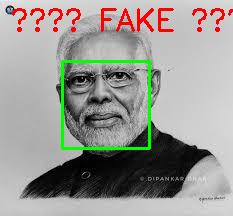

In [13]:
# @title Step 9: Test Model on a Single IMAGE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import cv2
import numpy as np
import os
from google.colab import drive
import mediapipe as mp
from google.colab.patches import cv2_imshow # Use cv2_imshow for Colab

# --- 1. Configuration ---
# ❗ Make sure these paths are correct
GDRIVE_PROJECT_PATH = "/content/drive/MyDrive/Deepfake_Project/"
FINAL_MODEL_WEIGHTS_PATH = os.path.join(GDRIVE_PROJECT_PATH, "fine_tuned_model_weights.weights.h5")

# ❗ UPDATE THIS PATH to a test image in your Drive
TEST_IMAGE_PATH = "/content/drive/MyDrive/Datasets/modi-fake2.jpg"

IMAGE_SIZE = (224, 224)

# --- 2. Mount Drive and Load Model ---
print("Mounting Drive...")
drive.mount('/content/drive', force_remount=True)

print("Building model architecture...")
# Rebuild the model architecture exactly as in Stage 2
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(*IMAGE_SIZE, 3))
# Unfreeze for fine-tuning structure, though we are only loading weights for inference
base_model.trainable = True
model = Sequential([base_model, layers.GlobalAveragePooling2D(), layers.Dropout(0.3), layers.Dense(1, activation='sigmoid')])

# Compile the model (required before loading weights in some Keras versions, good practice)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Use the same learning rate as fine-tuning or a dummy one
              loss='binary_crossentropy',
              metrics=['accuracy'])

print(f"Loading trained model weights from {FINAL_MODEL_WEIGHTS_PATH}...")
# Load only the weights into the rebuilt model
model.load_weights(FINAL_MODEL_WEIGHTS_PATH)
print("Model weights loaded successfully.")

# --- 3. Initialize Face Detector ---
face_detection = mp.solutions.face_detection.FaceDetection(min_detection_confidence=0.5)

# --- 4. Load and Process the Image ---
print(f"Opening image file: {TEST_IMAGE_PATH}")
frame = cv2.imread(TEST_IMAGE_PATH)

if frame is None:
    print("Error: Could not read image file.")
else:
    # Detect face with MediaPipe
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = face_detection.process(image_rgb)

    if results.detections:
        detection = results.detections[0]
        box = detection.location_data.relative_bounding_box
        h, w, _ = frame.shape
        x, y, W, H = int(box.xmin*w), int(box.ymin*h), int(box.width*w), int(box.height*h)

        # Crop the face
        cropped_face = frame[max(0, y):y+H, max(0, x):x+W]

        if cropped_face.size > 0:
            # Preprocess the face for the model
            face_resized = cv2.resize(cropped_face, IMAGE_SIZE)
            face_array = keras.utils.img_to_array(face_resized)
            face_expanded = np.expand_dims(face_array, axis=0)
            face_processed = preprocess_input(face_expanded)

            # Get a prediction
            prediction = model.predict(face_processed, verbose=0)
            score = prediction[0][0]

            # --- 5. Show Final Verdict ---
            print("\n--- FINAL VERDICT ---")
            # Assuming 0 is real, 1 is fake (based on your label setup)
            if score > 0.5:
                verdict = f"🔴 FAKE 🔴 (Confidence: {score * 100:.2f}%)"
            else:
                verdict = f"🟢 REAL 🟢 (Confidence: {(1 - score) * 100:.2f}%)"

            print(verdict)

            # Draw verdict on the original image and display it
            cv2.rectangle(frame, (x, y), (x+W, y+H), (0, 255, 0), 2)
            cv2.putText(frame, verdict, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
            cv2_imshow(frame)

        else:
            print("Detected a face, but crop was empty.")
    else:
        print("\n--- ANALYSIS FAILED ---")
        print("Could not detect any faces in the image.")